# **TP2 - k- plus proches voisins**

**Imports**

In [286]:
# question 1
from tpknnsource import *

# question 2
import numpy as np
import matplotlib.pyplot as plt

# question 4
from sklearn.base import BaseEstimator, ClassifierMixin
from math import sqrt
from scipy.stats import mode
from itertools import islice
from sklearn.neighbors import KNeighborsClassifier

# question 5

# question 7
from math import exp
from math import pow

# question 10
from sklearn.model_selection import train_test_split

# question 12
#import plot_digits_classification

# question 19
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from math import log

**1. Génération artificielle des données**

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les
visualiser facilement) à savoir p = 2 dans le formalisme ci-dessus. On reprend en partie les jeux de données
artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

1) Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? 

<font color = blue>i) A partir de deux variables de Gauss, dont les moyennes et les matrices de variance-covariance sont données en argument, la fonction rand-bi-gauss génère n1 et n2 échantillons de ces deux lois Normales. La fonction renvoie deux sorties: une matrice X de taille (n1+n2, 2), contenant les échantillons, et un vecteur y d´étiquettes valant soit 1 soit -1. Ces étiquettes sont attribuées aux échantillons de manière aléatoire.

<font color = blue>ii) La fonction rand-tri-gauss, à partir de moyennes (mu1, mu2, mu3) et de matrices sigma1, sigma2, sigma3, génère des échantillons de lois normales de paramètres (mu1, sigma1), (mu2, sigma2) et (mu3, sigma3) respectivement. Elle renvoie X, une matrice de taille (n1+n2+n3,2) contenant les échantillons des lois normales (dispersés en ordre aléaloire), ainsi qu´un vecteur y d´étiquettes attribuées au hasard à ces échantillons.

<font color = blue> iii) La fonction rand-clown génère un mélange de deux distributions: la première consiste en des points situés sur une parabole, tandis que la seconde est une Gaussienne centrée et de covariance sigma2. Pour des paramètres sigma1 et sigma2 bien choisis, ces deux distributions peuvent former la bouche et les yeux d´un personnage / d´un clown.

<font color = blue> iv) La fonction rand-checkers

Générez les données en utilisant chacune de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers prenez 150 pour les deux premiers arguments ; pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1; 1) (1;1)T et (1;1)T, tous les écart-types égaux à 0:9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [2]:
# rand_bi_gauss
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

In [3]:
# rand_tri_gauss
n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
sigmas3 = [0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigmas1, sigmas2, sigmas3)

In [4]:
# rand-clown
n1 = 50
n2 = 50
sigmas1 = 1.
sigmas2 = 5.
X3, y3 = rand_clown(n1, n2, sigmas1, sigmas2)

In [5]:
# rand-checkers
n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

**2. Data plot**

Utilisez la fonction plot_2d afin d’afficher les jeux de données générés avec chacune des fonctions.

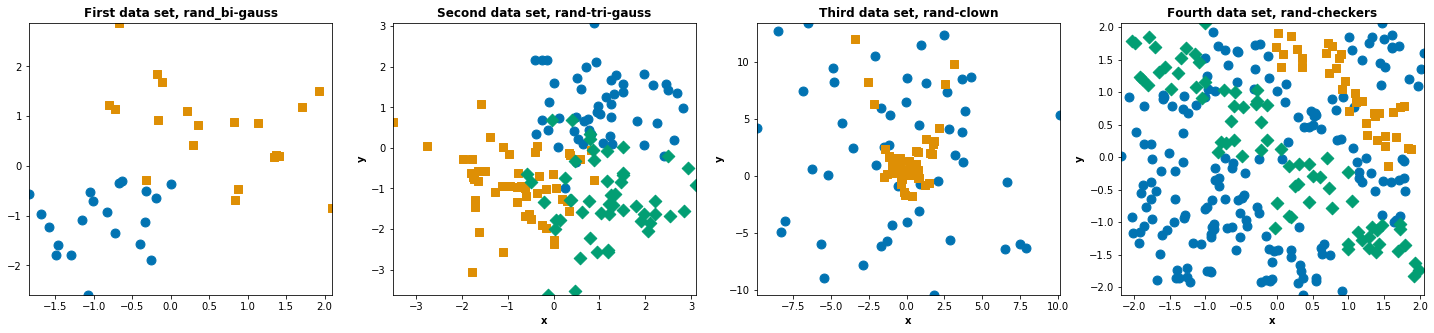

In [7]:
plt.close("all")
plt.figure(1, figsize=(25, 5))

# rand-bi-.gauss
plt.subplot(141)
plt.title('First data set, rand_bi-gauss', weight = 'bold')
plot_2d(X1, y1)

# rand-tri-gauss
plt.subplot(142)
plt.title('Second data set, rand-tri-gauss', weight = 'bold')
plt.xlabel('x', weight = 'bold')
plt.ylabel('y', weight = 'bold')
plot_2d(X2, y2)

# rand-clown-gauss
plt.subplot(143)
plt.title('Third data set, rand-clown', weight = 'bold')
plot_2d(X3, y3)
plt.xlabel('x', weight = 'bold')
plt.ylabel('y', weight = 'bold')

# rand-checkers
plt.subplot(144)
plt.title('Fourth data set, rand-checkers', weight = 'bold')
plot_2d(X4, y4)
plt.xlabel('x', weight = 'bold')
plt.ylabel('y', weight = 'bold')
plt.show()

**Approche intuitive**

L’algorithme des k-plus proches voisins (k-nn : pour k-nearest neighbors en anglais) est un algorithme
intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque
d’étiquettes.
Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point x on commence
par déterminer l’ensemble de ses k-plus proches voisins parmi les points d’apprentissage que l’on note
Vk(x) (bien sûr on doit choisir 1  k  n pour que cela ait un sens). La classe que l’on affecte au nouveau
point x est alors la classe majoritaire dans l’ensemble Vk(x). Une illustration de la méthode est donnée
en Figure 1 pour le cas de trois classes.

3) Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y
sont à valeurs réelles : Y = R.

<font color = blue>If the observations take real values, one can: 
    
<font color = blue>i) Compute the averages for each of the three data set 
    
<font color = blue>ii) Choose k, the number of neighours 
    
<font color = blue>iii) When a new point Xnew is to be classified: 
     
   - <font color = blue>Compute the average of Y for these k neighbours 
   - <font color = blue>Classify the new point Xnew in the group whose average is the closest to the average computed for the k neighbours

**Approche formelle**

4) Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification
predict.

In [8]:
class KNNClassifier(BaseEstimator, ClassifierMixin):

    # initialisation of the number of neighbours
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):                             # Will be called to train a sample X with the labels y
        self.X = X
        self.Y = y
        return self

    def predict(self, X):
        # compute the euclidian distance to all the other points
        k = self.n_neighbors
        dic = {}
        dic_e = {}                        # dictionary containing {the indice : the distance}
        p = 0
        List_labels = []
        # for z in self.X:
        z = self.X
        for e in X:
            for i in range(len(X)):
                e_distance = sqrt((e[0] - z[i, 0]) **
                                  2 + (e[1] - z[i, 1]) ** 2)
                dic_e[i] = e_distance
                #i = i +1
            dic[p] = dic_e

            # sort the calculated distances in ascending order (= sort according the values of the dictionary)
            sorted_dic_e = sorted(dic_e.items(), key=lambda t: t[1])

            # determine the k closest neighbours
            dic_e_neighbours = {}
            for i, dist in islice(sorted_dic_e, k):
                dic_e_neighbours[i] = dist

            # get the list of the indices of the k closest neighbours
            L = []
            for key in dic_e_neighbours.keys():
                L.append(key)

            # determine the labels of these k-closest neighbours.
            Y_k_neighbours = self.Y[L]
            X_label, count = mode(Y_k_neighbours)
            X_label = X_label[0]
            List_labels.append(int(X_label))
        return List_labels

Vérifier la validité des résultats
en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de
données #2.

<font color = blue> The results of the homemade code are compared to the results of the scikit-learn method by choosing the even indices of the initial sample as the train sample and the uneven incidices as the test sample.  

In [9]:
# The sample is split in two; one set for the train phase and one set for the test phase;
# For the train phase, the even indices of the original sample are used; the unven indices of the original sample for the test
Xtrain = X2[::2]   # Xtrain contains the even indices of X2
ytrain = y2[::2]   # ytrain contains the even indices of y2

Xtest = X2[1::2]   # Xtest contains the unven indices of X2
ytest = y2[1::2]   # ytrain contains the uneven indices of y2

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(Xtrain, ytrain)

print(f"Labels predicted by scikit-learn for X2: {classifier.predict(Xtest)}")

homemade = KNNClassifier(3)
homemade.fit(X2[::2], y2[::2])

print(
    f"Labels predicted by the Homemade KNN classifier: {homemade.predict(Xtest)}")

Labels predicted by scikit-learn for X2: [3. 3. 1. 2. 1. 3. 3. 3. 3. 1. 3. 1. 2. 1. 2. 3. 1. 3. 2. 1. 1. 1. 2. 1.
 1. 2. 3. 2. 1. 1. 3. 1. 2. 1. 1. 1. 3. 2. 1. 2. 1. 3. 1. 1. 1. 1. 2. 2.
 2. 2. 3. 1. 1. 3. 1. 2. 1. 3. 2. 3. 2. 1. 2. 1. 2. 3. 2. 3. 2. 2. 1. 3.
 1. 1. 2.]
Labels predicted by the Homemade KNN classifier: [3, 3, 1, 2, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1, 2, 3, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 1, 3, 1, 2, 1, 1, 1, 3, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 2, 3, 2, 1, 2, 1, 2, 3, 2, 3, 2, 2, 1, 3, 1, 1, 2]


<font color = blue>Hence, although the above code is certainly not the best, the results are the same as those given by scikit-learn

**5. Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant
la distance euclidienne classique**

In [10]:
number_neighbors = 5

# rand_bi_gauss
classifier_rand_bi_gauss = KNeighborsClassifier(n_neighbors=number_neighbors)
classifier_rand_bi_gauss.fit(X1[::2], y1[::2])

# rand_tri_gauss
classifier_rand_tri_gauss = KNeighborsClassifier(n_neighbors=number_neighbors)
classifier_rand_tri_gauss.fit(X2[::2], y2[::2])

# rand_clown
classifier_rand_clown = KNeighborsClassifier(n_neighbors=number_neighbors)
classifier_rand_clown.fit(X3[::2], y3[::2])

# rand_checkers
classifier_rand_checkers = KNeighborsClassifier(n_neighbors=number_neighbors)
classifier_rand_checkers.fit(X4[::2], y4[::2])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

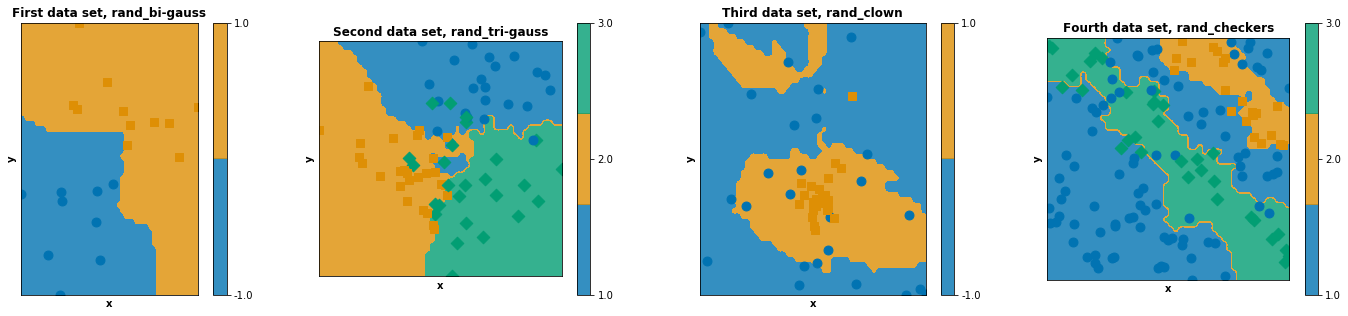

In [12]:
plt.close("all")
plt.figure(1, figsize=(25, 5))

# rand_bi_gauss
def f_rand_bi_gauss(x):
    return classifier_rand_bi_gauss.predict(x.reshape(1, -1))

plt.subplot(141)
plt.title('First data set, rand_bi-gauss', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_bi_gauss, X1[1::2], y1[1::2])


# rand_tri_gauss
def f_rand_tri_gauss(x):
    return classifier_rand_tri_gauss.predict(x.reshape(1, -1))

plt.subplot(142)
plt.title('Second data set, rand_tri-gauss', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_tri_gauss, X2[1::2], y2[1::2])


# rand_clown
def f_rand_clown(x):
    return classifier_rand_clown.predict(x.reshape(1, -1))

plt.subplot(143)
plt.title('Third data set, rand_clown', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_clown, X3[1::2], y3[1::2])


# rand_checkers
def f_rand_checkers(x):
    return classifier_rand_checkers.predict(x.reshape(1, -1))

plt.subplot(144)
plt.title('Fourth data set, rand_checkers', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_checkers, X4[1::2], y4[1::2])

**6) Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris
en compte : k = 1, ... , n**

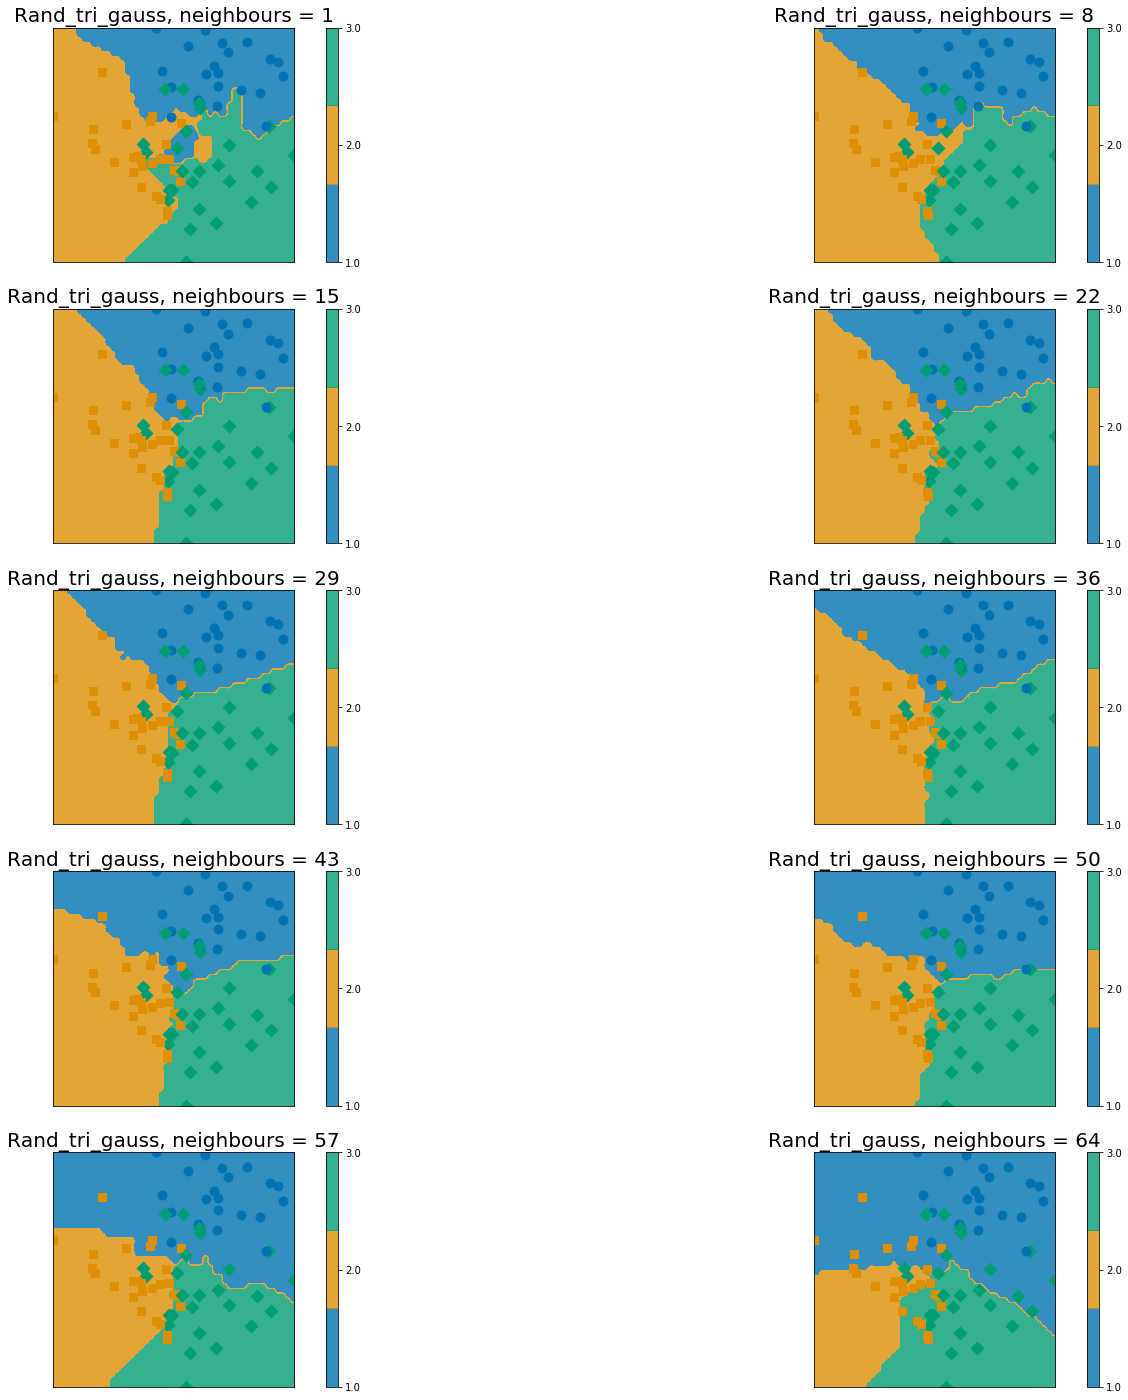

In [14]:
plt.close("all")
plt.figure(1, figsize=(25, 25))

i = 1
for neighbours in range(1, 70, 7):
    
    # fit the observations
    classifier_rand_tri_gauss = KNeighborsClassifier(n_neighbors=neighbours)
    
    # training on the even observations
    classifier_rand_tri_gauss.fit(X2[::2], y2[::2])

    # predict
    def f_rand_tri_gauss(x):
        return classifier_rand_tri_gauss.predict(x.reshape(1, -1))

    # plot
    plt.subplot(5, 2, i)
    plt.title(f"Rand_tri_gauss, neighbours = {neighbours}", fontsize=20)

    frontiere_new(f_rand_tri_gauss, X2[1::2], y2[1::2])

    i = i + 1

**Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher
ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une
forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?**

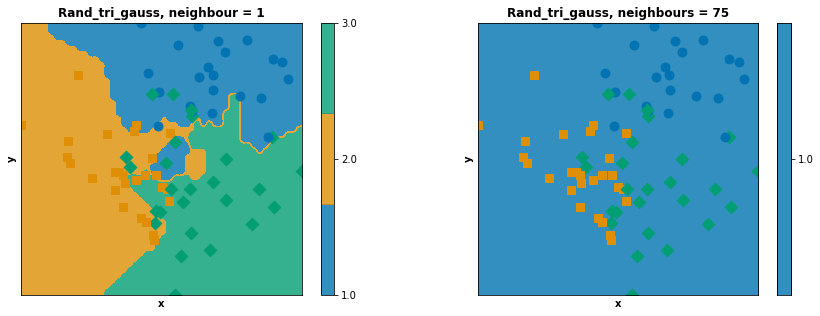

In [19]:
plt.close("all")
plt.figure(figsize=(15, 5))

# Case where k = 1, 1 neighbour
classifier_rand_tri_gauss = KNeighborsClassifier(n_neighbors=1)
classifier_rand_tri_gauss.fit(X2[::2], y2[::2])

def f_rand_tri_gauss(x):
    return classifier_rand_tri_gauss.predict(x.reshape(1, -1))

plt.subplot(121)
plt.title(f"Rand_tri_gauss, neighbour = 1", weight = 'bold')
plt.xlabel('x', weight = 'bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_tri_gauss, X2[1::2], y2[1::2])

# Case where  k = n, 75 neighbours
classifier_rand_tri_gauss = KNeighborsClassifier(n_neighbors=75)
classifier_rand_tri_gauss.fit(X2[::2], y2[::2])

plt.subplot(122)
plt.title(f"Rand_tri_gauss, neighbours = 75", weight = 'bold')
plt.xlabel('x', weight = 'bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_rand_tri_gauss, X2[1::2], y2[1::2])

<font color = blue>The graphs above show that in the case where one considers 1 neighbour only for each new observation to class, the frontier is much more complex, as any close neighbor may swiftly change the label.\
On the opposite, when considering the whole sample as a single neighbour, the labels are no more distinguished and one can see only 1 region on the graph; there is no frontier any more.

**7. Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon $\exp{(-\frac{d_{j}^{2}}{h})} $ (h contrôlant le niveau de pondération) : cela revient à remplacer l’Équation (2) par :**

Pour tester l’impact du choix de h sur les frontières de classification,
visualisez les règles de classification pour k = 7 et h = 10^j avec j = -2,-1, 0, 1, 2.\
Utilisez les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez utiliser la fonction frontiere_new.)

In [49]:
dic = {}
i = 0
for j in [-2, -1, 0, 1, 2]:
    dic[i] = j
    i = i + 1
dic

{0: -2, 1: -1, 2: 0, 3: 1, 4: 2}

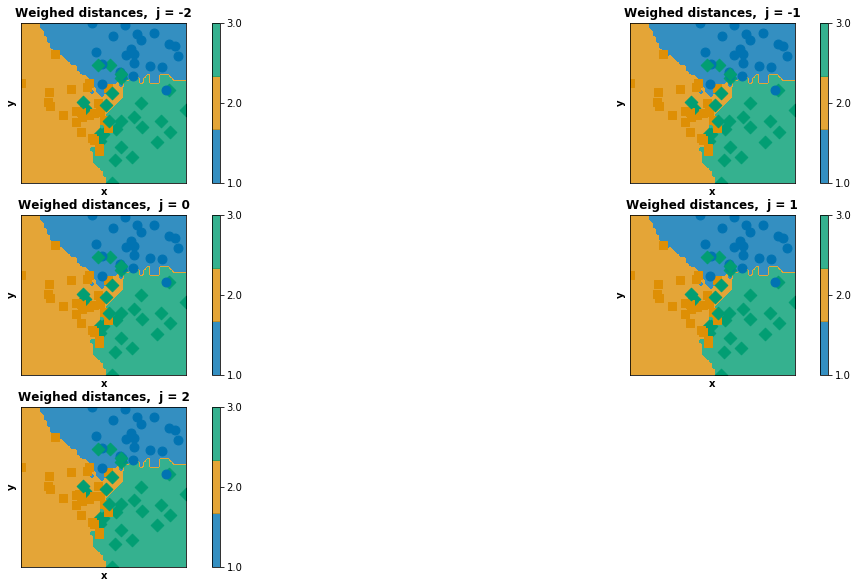

In [55]:
# define the user function for the argument 'weights' of the classifier (default is 'uniform', as in the previous questions)

def weight_function():
    L = []
    for j in [-2, -1, 0, 1, 2]:
        h = pow(10, j)

        def weight(dist):
            return np.exp(-dist**2/h)
        L.append(weight)
    return L

dic = {}
i = 0
for j in [-2, -1, 0, 1, 2]:
    dic[i] = j
    i = i + 1

plt.figure(figsize=(20, 10))
i = 1
for weight in weight_function():
    
    # define the KNeighborsClassifier, training the model on the even indices of the intial sample
    classifier_weighed = KNeighborsClassifier(n_neighbors=7, weights=weight)
    classifier_weighed.fit(X2[::2], y2[::2])

    # Test the model on the unven indices of the initial sampe
    def f_(x):
        return classifier_weighed.predict(x.reshape(1, -1))

    # plot
   
    plt.subplot(3,2,i)
    plt.title(f"Weighed distances,  j = {dic[i-1]}", weight='bold')
    plt.xlabel('x', weight='bold')
    plt.ylabel('y', weight='bold')
    frontiere_new(f_, X2[1::2], y2[1::2])
    
    i = i + 1

8) Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite
par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [76]:
# Classifier in the case k = 1
knnClassifierTrain = KNeighborsClassifier(n_neighbors=1)
# Error on the train data
knnClassifierTrain.fit(X2[::2], y2[::2])
errorTrain = 1-knnClassifierTrain.score(X2[::2], y2[::2])
print("Mean accuracy on the on the given train data and labels: {:.2f}%".format(100*(1-errorTrain)))
print("Error on the given train data and labels: {:.2f}%".format(errorTrain))

Mean accuracy on the on the given train data and labels: 100.00%
Error on the given train data and labels: 0.00%


<font color = blue> When training on the extreme case with 1 neighbor only, the model does not make any error on the train sample.

In [322]:
# Classifier in the case k = 1
knnClassifierTest = neighbors.KNeighborsClassifier(n_neighbors=1)
# Error on the test data
knnClassifierTest.fit(X2[::2], y2[::2])
errorTest = 1-knnClassifierTest.score(X2[1::2], y2[1::2])
print("Mean accuracy on the given test data and labels: {:.2f}%".format(100*(1-errorTest)))
print("Error on the given test data and labels: {:.2f}%".format(errorTest))

Mean accuracy on the given test data and labels: 73.33%
Error on the given test data and labels: 0.27%


<font color = blue> But this does not guarantee that the model is correct, as is seen here: one third of the test data is not correctly labelled. This shows the overfitting on the train data when fitting on every single neighbor (k=1). 

**9. Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations
d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, ... 50.
Vous pourrez utiliser la classe fournie ErrorCurve.**

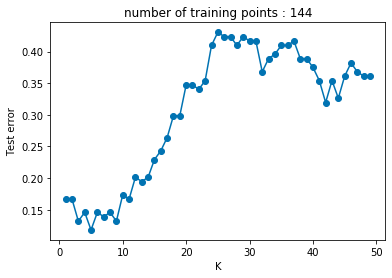

In [85]:
k_range = range(1,50)
curve = ErrorCurve(k_range = k_range)
curve.fit_curve(X4[::2], y4[::2], X4[1::2], y4[1::2])
curve.plot()

**10. Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, ... 50) sur le jeu de
données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille.**

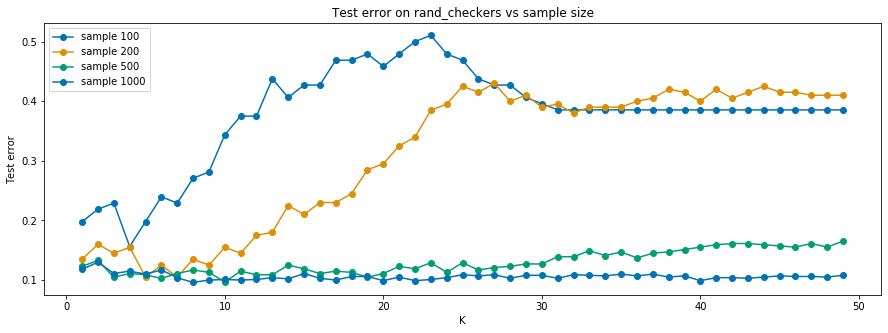

In [106]:
# (Not sure I understood the question)

sample_size = [100, 200, 500, 1000]
plt.figure(figsize=(15,5))
for n in sample_size[:4]:
    # generate the rand_checkers sample
    X4,y4 = rand_checkers(n, n, 0.1)
    
    # split it into a training and a test samples
    X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.5, random_state=42)
    
    # plot the errors
    k_range = range(1,50)
    curve = ErrorCurve(k_range = k_range)
    curve.fit_curve(X4_train, y4_train, X4_test, y4_test)
    label = "sample " + str(n)
    curve.plot(label = label)
    plt.title('Test error on rand_checkers vs sample size')
    plt.legend()
    
    

<font color = blue> - The best value for n depends on the sample size:\
            <font color = blue>  + approx. 4 for n = 100 \
            <font color = blue>  + approx. 5 for n = 200 \
            <font color = blue>  + approx. 10 for n = 500 \
            <font color = blue>  + approx. 20 for n = 1000 \

<font color = blue> - The bigger the sample, the lower the test error
    
<font color = blue> - With a big sample size, there is no need to choose a high value for k. As can be seen for n = 500, the error even slightly increases with increasing k.

Pour n = 1000 visualisez les données et la règle de décision sur le même graphique.

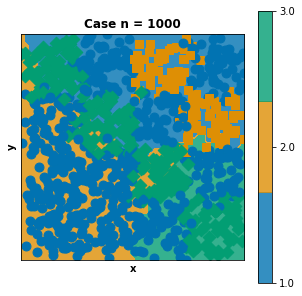

In [109]:
plt.figure(figsize=(5,5))
plt.title('Case n = 1000', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_, X4_test, y4_test)

**11. A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins :
temps de calcul ? passage à l’échelle ? interprétabilité ?**

**12. Étudiez la base digits de scikit-learn.
On pourra se référer à http://scikit-learn.org/stable/_downloads/plot_digits_classification.py pour le chargement et la manipulation de la base de données.**


Recognizing hand-written digits

An example showing how the scikit-learn can be used to recognize images of
hand-written digits.

This example is commented in the
:ref:`tutorial section of the user manual <introduction>`.


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0

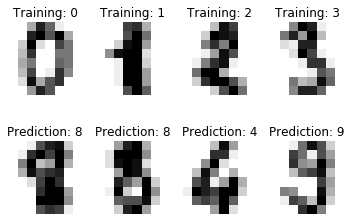

In [114]:
"""
================================
Recognizing hand-written digits
================================

An example showing how the scikit-learn can be used to recognize images of
hand-written digits.

This example is commented in the
:ref:`tutorial section of the user manual <introduction>`.

"""
print(__doc__)

# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()


In [154]:
digits = datasets.load_digits()
digits.target

array([0, 1, 2, ..., 8, 9, 8])

<font color = blue> The dataset 'digits' is a Bunch comprising of:\
<font color = blue> - data, a ndarray of shape (1797, 64) of floats\
<font color = blue> - target, a ndarray of shape (1797,) containing integers from 0 to 9, plus the integer 8\
<font color = blue> - target_names, a ndarray of shape (1797,) containing integers from 0 to 9\
<font color = blue> - images, a ndarray of shape (1797,8,8)
<font color = blue> - DESCR, a string; this is a description of the dataset

Afficher un exemple\
<font color = blue> The dataset is made of 1797 images.\
<font color = blue> Each image is made of 8x8 squares/pixels, each having a certain colour; each image represents an integer, that the model should predict.\
<font color = blue> The real value corresponding to the image is known and stored in the 'target' attribute of the dataset.

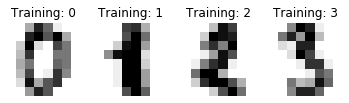

In [157]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


Tracez l’histogramme pour des classes

(array([0.55029988, 0.        , 0.        , 0.        , 0.        ,
        0.56266617, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.54720831, 0.        , 0.        , 0.        ,
        0.        , 0.56575774, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5595746 , 0.        , 0.        ,
        0.        , 0.        , 0.56266617, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.5595746 , 0.        ,
        0.        , 0.        , 0.        , 0.55339145, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.53793359,
        0.        , 0.        , 0.        , 0.        , 0.55648303]),
 array([0.  , 0.18, 0.36, 0.54, 0.72, 0.9 , 1.08, 1.26, 1.44, 1.62, 1.8 ,
        1.98, 2.16, 2.34, 2.52, 2.7 , 2.88, 3.06, 3.24, 3.42, 3.6 , 3.78,
        3.96, 4.14, 4.32, 4.5 , 4.68, 4.86, 5.04, 5.22, 5.4 , 5.58, 5.76,
        5.94, 6.12, 6.3 , 6.48, 6.66, 6.84, 7.02, 7.2 , 7.38, 7.56, 7.74,
        7.92, 8.1 , 8.

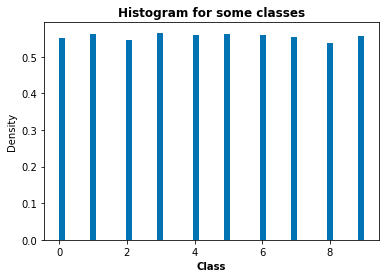

In [168]:
label_list = []

for index, (image, label) in enumerate(images_and_labels):
    label_list.append(label)

plt.title('Histogram for some classes', weight = 'bold')
plt.xlabel('Class', weight = 'bold')
plt.ylabel('Density')
plt.hist(label_list ,bins = 50, density = True)

Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième
pour le test.\
<font color = blue> Use of the source code in plot_digits_classification

In [187]:
# USE OF THE CODE IN plot_digits_classification:

# To apply a classifier on this data, we need to flatten the image, to turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("Taux d´erreur: {:.2f} ".format(1-metrics.r2_score(expected, predicted)))

Taux d´erreur: 0.07 


**13. Estimez la matrice de confusion.**

In [183]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


**14. Proposez une méthode pour choisir k et mettez-la en oeuvre. Vous pourrez utiliser la classe fournie LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour k = 1; 6; 11; 16; 21; 26; 31; 36; 41; 46; 100; 200.**

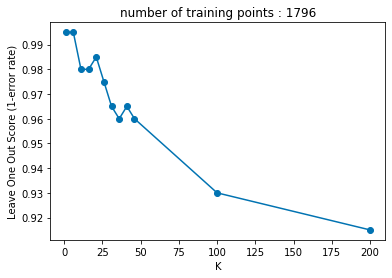

In [192]:
k_list = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
looCurve = LOOCurve(k_range = k_list)
looCurve.fit_curve(digits.data, digits.target)
looCurve.plot()

**Aspect théorique**

**15. En utilisant la formule de Bayes donner la formule des probabilités a posteriori** $ P{ ( Y = + 1 | X = x ) } $

$ P{ ( Y = + 1 | X = x ) }  =  \frac {    P{ ( Y = + 1 , X = x ) }    }{P(X = x)}   $           (Bayes Formula)

$ P{ ( Y = + 1 | X = x ) }  =  \frac {    P{ ( X = x | Y = +1 ) . P(Y = +1)}    }{P(X = x)}   $           (Bayes Formula)

$ P{ ( Y = + 1 | X = x ) }  =  \frac {    P{ ( X = x | Y = +1 ) . P(Y = +1)}    }{P(X = x|Y=+1).P(Y=+1) + P(X = x|Y=-1).P(Y=-1)}   $           (Total probabilities Formula)

$ P{ ( Y = + 1 | X = x ) }  =  \frac {\Pi_{+}}    {\Pi_{+}  + \frac{P(X=x|Y=-1)}{P(X=x|Y=+1)}.\Pi_{-}}   $           (Total probabilities Formula)

$ P{ ( Y = + 1 | X = x ) }  =  \frac {\Pi_{+}}    {\Pi_{+}  + \frac{f_{-}}{f_{+}}.\Pi_{-}}   $           (Total probabilities Formula)

$ P{ ( Y = + 1 | X = x ) }  =  \frac {\Pi_{+}f_{+}}    {\Pi_{+}f_{+}  + \Pi_{-}f_{-}}   $           (Total probabilities Formula)

$ P{ ( Y = - 1 | X = x ) }  =  \frac {\Pi_{-}f_{-}}    {\Pi_{-}f_{-}  + \Pi_{+}f_{+}}   $           (Similarly)

**16. Exprimer le log-ratio des deux classes** Log($\frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x}$)

$\log(\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )}) = \log( \frac{\Pi_{+}}{\Pi{-}}) + \log(\frac{f_{+}}{f_{-}})  $

$\log(\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )}) = \log( \frac{\Pi_{+}}{1-\Pi{+}}) -\frac{1}{2}.(x-\mu_{+})^{T}.\Sigma^{-1}.(x-\mu_{+}) + \frac{1}{2}.(x-\mu_{-})^{T}.\Sigma^{-1}.(x-\mu_{-})  $

$\log(\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )}) = \log( \frac{\Pi_{+}}{1-\Pi{+}}) -\frac{1}{2}.(x-\mu_{+})^{T}.\Sigma^{-1}.(x-\mu_{+}) + \frac{1}{2}.(x-\mu_{-})^{T}.\Sigma^{-1}.(x-\mu_{-})  $

$\log(\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )}) = \log( \frac{\Pi_{+}}{1-\Pi{+}}) + x^{T}\Sigma^{-1}(\mu_{+}-\mu_{-}) - \frac{1}{2}.\mu_{+}^{T}.\Sigma^{-1}\mu_{+} + \frac{1}{2}.\mu_{-}^{T}.\Sigma^{-1}\mu_{-}  $

**17. Justifier le choix du classifieur suivant :**

1 si $x^{T}\Sigma^{-1}(\mu_{+}-\mu_{-}) > \frac{1}{2}.\mu_{+}^{T}\Sigma^{-1}\mu_{+} + \frac{1}{2}.\mu_{-}^{T}\Sigma^{-1}\mu_{-}  $ 

-1 sinon

<font color = blue> The question is how to classify the observation x, so it all boils down to the following question: is the probability P(Y = +1 | X = x) > P(Y = -1 | X = x).
<font color = blue> This means exactly that Log($\frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x}$) >0 \
<font color = blue> Given the result of the question 16 and replacing the theoretical values by their corresponding empirical values, it holds that:   

$\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )} >1
\Longleftrightarrow$ $\log(\frac{ P ( Y = + 1 | X = x ) }{ P ( Y = - 1 | X = x )}) >0
\Longleftrightarrow$

$ x^{T}\Sigma^{-1}(\mu_{+}-\mu_{-}) > \frac{1}{2}.\mu_{+}^{T}\Sigma^{-1}\mu_{+} - \frac{1}{2}.\mu_{-}^{T}\Sigma^{-1}\mu_{-}  - \log( \frac{\Pi_{+}}{1-\Pi{+}}) $

$\Longleftrightarrow$

$ x^{T}\hat{\Sigma}^{-1}(\hat{\mu}_{+}-\hat{\mu}_{-}) > \frac{1}{2}.\hat{\mu}_{+}^{T}\hat{\Sigma}^{-1}\hat{\mu}_{+} - \frac{1}{2}.\hat{\mu}_{-}^{T}\hat{\Sigma}^{-1}\hat{\mu}_{-}  - \log( \frac{m}{n}) + \log{1-\frac{m}{n}}) $

<font color = blue> Similarly, x is classified with the label {-1} if P(Y = -1 | X = x) > P(Y = +1 | X = x)  

**18. Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification
predict.** 

In [315]:
class LDAClassifier(BaseEstimator, ClassifierMixin):

    # initialisation of the number of neighbours
   # def __init__(self):
        # self.XXX =

    def fit(self, X, y):
        self.X = X
        self.Y = y
        return self

    def predict(self, X):
        # compute the different elements of the classifier of question 17
        # Pi+ and Pi-, i.e m and n
        X_plus = self.X[self.Y == 1,:]
        X_minus = self.X[self.Y == -1,:]
        X_plus_0 = X_plus[:,0]
        X_plus_1 = X_plus[:,1]
        
        n = len(self.X)
        m = len(X_plus)
    
        # mu+ and mu-
        mu_plus_0 = (X_plus[:,0]).sum() / m
        mu_plus_1 = (X_plus[:,1]).sum() / m
        mu_plus = np.array([mu_plus_0,mu_plus_1])
        
        mu_minus_0 = (X_minus[:,0]).sum() / (n - m)
        mu_minus_1 = (X_minus[:,1]).sum() / (n - m )
        mu_minus = np.array([mu_minus_0,mu_minus_1])

        # Sigma
        Sigma_plus = (np.dot((X_plus - mu_plus).T, (X_plus - mu_plus)))/(m-1)
        Sigma_minus = (np.dot( (X_minus - mu_minus).T, (X_minus - mu_minus))) / (n - m - 1)
        Sigma = ((m-1) * Sigma_plus + (n - m - 1)*Sigma_minus) / (n - 2)
        
        # compute the classifier and construct y_predicted
        criterion = 0.5*np.dot(mu_plus, np.dot(np.linalg.inv(Sigma),mu_plus)) - 0.5*np.dot(mu_minus, np.dot(np.linalg.inv(Sigma),mu_minus)) + log(1-m/n) - log(m/n)
        
        y_predicted_list = []

        for i in range(len(X)):
            Xi = X[i]
            a = np.dot(Xi.T,np.dot(np.linalg.inv(Sigma),mu_plus-mu_minus))
        
            if a > criterion:
                y_predicted = 1
            else:
                y_predicted = -1
            y_predicted_list.append(y_predicted)
    
        return y_predicted_list

**19.Importez le module sklearn.discriminant_analysis qui contient en particulier la classe LinearDiscriminantAnalysis qui nous servira dans la suite.\
L’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand.**

<font color = blue> Test on the very first generated sample (X1, y1) from the rand_b_gauss function\
<font color = blue> The initial sample comprises 200 observations and m is not equal to (n-m). \
<font color = blue> The training sample is here made of 50 observations and the test sample of 150 observations.

In [319]:
# Test on the very first generated sample (X1, y1) from the rand_b_gauss function

# Simulated sample
# rand_bi_gauss
n1 = 50
n2 = 150
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

classifier_homemade =  LDAClassifier()
classifier_homemade.fit(X1[:50], y1[:50])
y1_predictions = classifier_homemade.predict(X1[150:])

Taux d´erreur

In [336]:
# Homemade classifier
errorTest_homemade = 1-classifier_homemade.score(X1[:50], y1[:50])
print("Mean accuracy on this data set with the homemade classifier: {:.2f}%".format(100*(1-errorTest_homemade)))
print("Error on the given test data with the homemade classifier: {:.2f}%".format(errorTest_homemade))
print("")

# sklearn classifier
LDA_classifier = LinearDiscriminantAnalysis()
LDA_classifier.fit(X1[:50], y1[:50])
LDA_classifier_errorTest = 1-classifier_homemade.score(X1[:50], y1[:50])
y1_predictions_LDAclassifier = LDA_classifier.predict(X1[150:])
print("Mean accuracy on this data set with the sklearn classifier: {:.2f}%".format(100*(1-LDA_classifier_errorTest)))
print("Error on the given test data with the sklearn classifier: {:.2f}%".format(LDA_classifier_errorTest))


Mean accuracy on this data set with the homemade classifier: 94.00%
Error on the given test data with the homemade classifier: 0.06%

Mean accuracy on this data set with the sklearn classifier: 94.00%
Error on the given test data with the sklearn classifier: 0.06%


**Nombre de cas où les prévisions coincident**

In [338]:
a = np.array(y1_predictions == y1[150:])
print(f"Number of correct predictions with the homemade classifier: {np.sum(a)} (out of 50) ")
print("")
LDA = np.array(y1_predictions_LDAclassifier == y1[150:])
print(f"Number of correct predictions with the sklearn classifier:  {np.sum(LDA)} (out of 50) ")

Number of correct predictions with the homemade classifier: 46 (out of 50) 

Number of correct predictions with the sklearn classifier:  46 (out of 50) 


**En utilisant votre classe LDAClassifier, visualisez la règle de classification.**

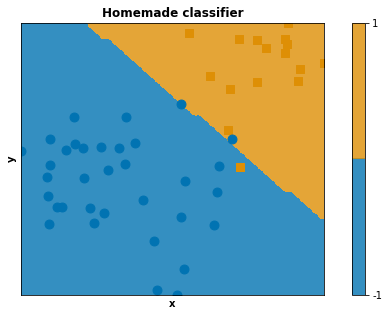

In [345]:
# classifier_homemade
classifier_homemade =  LDAClassifier()
classifier_homemade.fit(X1[:50], y1[:50])

def f_classifier_homemade(x):
    return classifier_homemade.predict(x.reshape(1, -1))

plt.figure(figsize = (10,5))
plt.title('Homemade classifier', weight='bold')
plt.xlabel('x', weight='bold')
plt.ylabel('y', weight='bold')
frontiere_new(f_classifier_homemade,X1[:50], y1[:50])